# WW Index and Cases Comparison

A notebook to assess correlation of `ww_index` with weekly cases for different geographies.

The assessment focuses on the 04-01-2021 to 04-01-2022 period which is assumed to have more reliable case data.

## Imports

- Public dataset of weekly cases by state
- State census regions dataset
- WW index dataset, modified to be on a wed to thurs schedule to match the cases dataset

In [1]:
from foundry.transforms import Dataset

cases = Dataset.get("Weekly_United_States_COVID_19_Cases_and_Deaths_by_State_Archived")\
  .read_table(format="arrow")\
  .to_pandas()

In [2]:
from foundry.transforms import Dataset

regions =  Dataset.get("state_ontology_copy")\
  .read_table(format="arrow")\
  .to_pandas()

abbrevs = Dataset.get("abbreviations_names")\
  .read_table(format="arrow")\
  .to_pandas()

In [3]:
from foundry.transforms import Dataset

nat_log = Dataset.get("ww_index_nat_log_thurs_to_wed_weekly")\
  .read_table(format="arrow")\
  .to_pandas()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
cases.new_cases.sum()

104657528

In [6]:
cases.new_cases.max()

790954

Filter data for desired target and date range, select only needed columns.

In [7]:
nat_log = nat_log[nat_log.pcr_target == 'sars-cov-2']

start_date = pd.to_datetime('2021-01-01').date()
end_date = pd.to_datetime('2023-05-10').date()

nat_log = nat_log[nat_log.week_end.between(start_date, end_date)]

# select desired fields from nat_log
fields = ['week_end', 'sample_collect_date', 'us_census_region_modified', 'State', 'ww_index_normed_ln_lin', 'site_id_with_pcr']
nat_log = nat_log[fields].sort_values(by='week_end')

nat_log.head(3)

,week_end,sample_collect_date,us_census_region_modified,State,ww_index_normed_ln_lin,site_id_with_pcr
748,2021-01-06,2021-01-03,West,California,14.483046,06075-001-01-00-00_sars-cov-2
83919,2021-01-06,2021-01-05,Midwest,Wisconsin,3.216306,55047-001-01-00-00_sars-cov-2
83920,2021-01-06,2021-01-05,Midwest,Wisconsin,2.312629,55057-001-01-00-00_sars-cov-2


In [8]:
unique_df = nat_log.groupby('State').nunique().reset_index()
unique_df = unique_df[['State', 'site_id_with_pcr']].sort_values('site_id_with_pcr', ascending=False)
unique_df.rename(columns={"State":"state"}, inplace=True)
unique_df

,state,site_id_with_pcr
33,New York,138
4,California,83
26,Missouri,81
14,Illinois,79
36,Ohio,79
23,Michigan,75
50,Wisconsin,65
5,Colorado,64
34,North Carolina,53
47,Virginia,46


## Cleaning

Cleaning and shaping two different datasets:
- ww_index dataset (nat_log)
- dataset with cases and geographies info (cases)

### Index dataset shaping

#### National medians

In [9]:
# aggregate ww index dataset to produce national weekly medians
national_medians_ln = nat_log.groupby('week_end')['ww_index_normed_ln_lin'].median().reset_index()
national_medians_ln.head(2)

,week_end,ww_index_normed_ln_lin
0,2021-01-06,6.747079
1,2021-01-13,6.031710


<Axes: xlabel='week_end'>

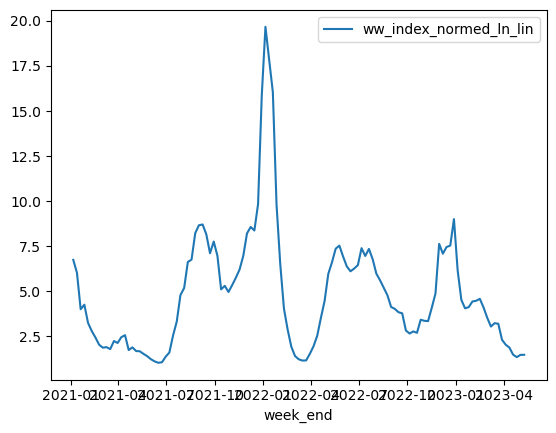

In [10]:
national_medians_ln.plot(x='week_end', y='ww_index_normed_ln_lin')

#### Regional medians

In [11]:
regional_medians_ln = nat_log.groupby(['week_end', 'us_census_region_modified'])['ww_index_normed_ln_lin'].median().reset_index()
regional_medians_ln.head(3)

,week_end,us_census_region_modified,ww_index_normed_ln_lin
0,2021-01-06,Midwest,5.506446
1,2021-01-06,Northeast,15.067255
2,2021-01-06,South,71.391086


#### State medians

In [12]:
state_medians_ln = nat_log.groupby(['week_end', 'State'])['ww_index_normed_ln_lin'].median().reset_index()
state_medians_ln.head(3)

,week_end,State,ww_index_normed_ln_lin
0,2021-01-06,California,10.820424
1,2021-01-06,Colorado,6.367984
2,2021-01-06,Massachusetts,18.722918


In [13]:
state_medians_ln.State.nunique()

52

### Cases dataset shaping

Import cases dataset, view it, rename fields to match index dataset, filter to desired timeframe.

In [14]:
cases.head(2)

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,2020-01-23,AK,2020-01-16,2020-01-22,0,0,0,0,0,0
1,2020-01-30,AK,2020-01-23,2020-01-29,0,0,0,0,0,0


In [15]:
cases.end_date.max()

datetime.date(2023, 5, 10)

In [16]:
fields = ['state', 'end_date','new_cases']
cases = cases[fields]
cases = cases.rename(columns={"end_date": "week_end", "new_cases":"cases_new"})

start_date = pd.to_datetime('2021-04-01').date()
end_date = pd.to_datetime('2023-05-10').date()

cases = cases[cases.week_end.between(start_date, end_date)]
cases.head(2)

,state,week_end,cases_new
63,AK,2021-04-07,1208
64,AK,2021-04-14,1113


Filter state ontology / regions dataset to desired fields, then modify handling of territories.

In [17]:
cases.state.nunique()

60

In [18]:
regions.columns
cols = ['state_name', 'us_census_region']
regions = regions[cols]
regions.head(3)

,state_name,us_census_region
0,American Samoa,None
1,Guam,None
2,Northern Mariana Islands,None


In [19]:
def census_region_filters(df):
    # Define a function to modify the us_census_region based on state_name
    def modify_region(row):
        if row['state_name'] in ['Guam', 'American Samoa', 'Commonwealth of the Northern Mariana Islands',
                                 'Federated States of Micronesia', 'Marshall Islands', 'Republic of Palau']:
            return 'West'
        elif row['state_name'] in ['Puerto Rico', 'Virgin Islands']:
            return 'Northeast'
        else:
            return row['us_census_region']

    # Apply the function to the DataFrame
    df['us_census_region_mod'] = df.apply(modify_region, axis=1)

    return df

regions = census_region_filters(regions).drop(columns=['us_census_region'])
regions.head(3)

,state_name,us_census_region_mod
0,American Samoa,West
1,Guam,West
2,Northern Mariana Islands,None


Add in the abbreviations so regions can be joined to cases.

In [20]:
abbrevs['juris_abbreviation'] = abbrevs['juris_abbreviation'].str.upper()
abbrevs.drop(columns=['reporting_jurisdiction'],inplace=True)
abbrevs.head(2)

,juris_abbreviation,state
0,AL,Alabama
1,AK,Alaska


In [21]:
regions = pd.merge(regions, abbrevs, left_on='state_name', right_on='state').drop(columns=['state_name'])
regions.head(3)

,us_census_region_mod,juris_abbreviation,state
0,West,GU,Guam
1,South,AL,Alabama
2,West,AK,Alaska


In [22]:
regions.state.nunique()

52

In [23]:
cases = pd.merge(cases, regions, left_on='state', right_on='juris_abbreviation')
cases.drop(columns=['state_x'], inplace=True)

In [24]:
cases.rename(columns={"juris_abbreviation":"state_abbrev", "state_y":"state"}, inplace=True)
cases

,week_end,cases_new,us_census_region_mod,state_abbrev,state
0,2021-04-07,1208,West,AK,Alaska
1,2021-04-14,1113,West,AK,Alaska
2,2021-04-21,1146,West,AK,Alaska
3,2021-04-28,1042,West,AK,Alaska
4,2021-05-05,731,West,AK,Alaska
...,...,...,...,...,...
5935,2023-04-12,158,West,WY,Wyoming
5936,2023-04-19,115,West,WY,Wyoming
5937,2023-04-26,140,West,WY,Wyoming
5938,2023-05-03,129,West,WY,Wyoming


In [25]:
cases.us_census_region_mod.value_counts()

us_census_region_mod
South        1980
West         1540
Midwest      1430
Northeast     990
Name: count, dtype: int64

In [26]:
cases.state.nunique()

52

#### National cases

<Axes: xlabel='week_end'>

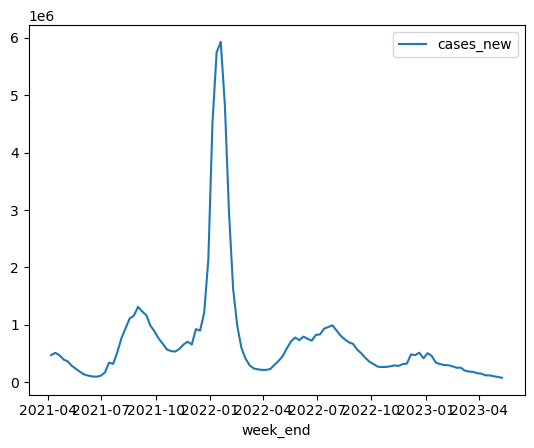

In [27]:
national_cases = cases.groupby('week_end')['cases_new'].sum().reset_index()
national_cases.plot(x='week_end', y='cases_new')

#### Regional cases

In [28]:
regional_cases = cases.groupby(['week_end','us_census_region_mod'])['cases_new'].sum().reset_index()
regional_cases.head(2)

,week_end,us_census_region_mod,cases_new
0,2021-04-07,Midwest,143728
1,2021-04-07,Northeast,118422


#### State cases

In [29]:
state_cases = cases.groupby(['week_end','state'])['cases_new'].sum().reset_index()
state_cases.head(2)

,week_end,state,cases_new
0,2021-04-07,Alabama,2095
1,2021-04-07,Alaska,1208


In [30]:
len(state_cases[state_cases.state.isna()])

0

## National Correlations

### Shaping and merging NATIONAL datasets

In [31]:
national_medians_ln.head(2)

,week_end,ww_index_normed_ln_lin
0,2021-01-06,6.747079
1,2021-01-13,6.031710


In [32]:
national_cases.head(2)

,week_end,cases_new
0,2021-04-07,472282
1,2021-04-14,510959


In [33]:
df_index_ln = national_medians_ln
df_cases = national_cases

# Convert 'week_end' to datetime for both datasets
df_index_ln['week_end'] = pd.to_datetime(df_index_ln['week_end'])
df_cases['week_end'] = pd.to_datetime(df_cases['week_end'])

# Drop rows with NaN in 'ww_index_normed_ln_lin' or index_log10 from the index dataset
df_index_ln.dropna(subset=['ww_index_normed_ln_lin'], inplace=True)

# Find the first week where 'cases_new' is not zero
first_non_zero_week = df_cases[df_cases['cases_new'] > 0]['week_end'].min()

print(f"first non-zero week is: {first_non_zero_week}")

# Filter both datasets to start from this week
df_index_ln = df_index_ln[df_index_ln['week_end'] >= first_non_zero_week]
df_cases = df_cases[df_cases['week_end'] >= first_non_zero_week]


first non-zero week is: 2021-04-07 00:00:00


In [34]:
# Merge the datasets
df_merged = pd.merge(df_index_ln, df_cases, on='week_end', how='inner')
df_merged.head(2)

,week_end,ww_index_normed_ln_lin,cases_new
0,2021-04-07,2.460417,472282
1,2021-04-14,2.572996,510959


### Write national dataset

In [35]:
from foundry.transforms import Dataset

national_cases_index_public_data = Dataset.get("national_cases_index_public_data")
national_cases_index_public_data.write_table(df_merged)

### Compare national correlations

First I check the simple linear correlation of cases and indices with the Pearson correlation coeff.

In [36]:
# Calculate Pearson correlation
correlation_ln = df_merged['ww_index_normed_ln_lin'].corr(df_merged['cases_new'])
print(f"The Pearson correlation coefficient for nat log index is: {correlation_ln}")

The Pearson correlation coefficient for nat log index is: 0.7862881222711726


There are other measures of correlation which are better suited to our use case since neither the cases nor index curve is linear.

**Spearman Rank Correlation** in particular seems appropriate:
This non-parametric measure does not assume a linear relationship between variables, instead, it assesses how well the relationship between two variables can be described using a monotonic function.

A **monotonic function** is a mathematical function that either never increases or never decreases as its independent variable increases. In the context of statistics and correlation, when we say that the relationship between two variables can be described using a monotonic function, we mean that as one variable increases, the other variable either consistently increases or consistently decreases, but the relationship does not necessarily have to be linear.

If our ww_index is indeed a good proxy for case counts, then we would expect to see a monotonic relationship between the index and cases.

In [37]:
# Calculate Spearman Rank Correlation
spearman_correlation_ln = df_merged['ww_index_normed_ln_lin'].corr(df_merged['cases_new'], method='spearman')
print(f"The Spearman correlation coefficient for nat log index is: {spearman_correlation_ln}")

The Spearman correlation coefficient for nat log index is: 0.8263237382503438


**However**, we might expect there to be a lag in the relationship between the index and cases. For example, it has been proposed that increases in wastewater SC2 RNA concentration precede rises in cases.

The following code tests a range of lags up to +/- 3 weeks.

#### Natural log Spearman lagged

In [38]:
# time-lagged cross-correlation using Spearman's rank correlation
max_lag = 3
for lag in range(-max_lag, max_lag + 1):
    shifted_cases = df_merged['cases_new'].shift(lag)
    # Use 'spearman' instead of 'pearson' for the method parameter
    correlation = df_merged['ww_index_normed_ln_lin'].corr(shifted_cases, method='spearman')
    print(f"Lag {lag} weeks: Spearman correlation coefficient = {round(correlation, 3)}")

Lag -3 weeks: Spearman correlation coefficient = 0.797
Lag -2 weeks: Spearman correlation coefficient = 0.852
Lag -1 weeks: Spearman correlation coefficient = 0.861
Lag 0 weeks: Spearman correlation coefficient = 0.826
Lag 1 weeks: Spearman correlation coefficient = 0.759
Lag 2 weeks: Spearman correlation coefficient = 0.656
Lag 3 weeks: Spearman correlation coefficient = 0.529


In [39]:
shifted_cases = df_merged['cases_new'].shift(-1)
shifted_cases.head(4)

0    510959.0
1    469691.0
2    394716.0
3    362593.0
Name: cases_new, dtype: float64

In [40]:
df_merged['cases_new'].head(4)

0    472282
1    510959
2    469691
3    394716
Name: cases_new, dtype: int32

From this result we can see that when the cases dataset is shifted back 1 to 2 weeks, it does slightly improve the correlation. This is nice since it supports that wastewater concentration rises precede cases.

## Regional correlations

In [41]:
df_index_ln = regional_medians_ln
df_cases = regional_cases

# Convert 'week_end' to datetime for both datasets
df_index_ln['week_end'] = pd.to_datetime(df_index_ln['week_end'])
df_cases['week_end'] = pd.to_datetime(df_cases['week_end'])

# Drop rows with NaN in 'ww_index_normed_ln_lin' or index_log10 from the index dataset
df_index_ln.dropna(subset=['ww_index_normed_ln_lin'], inplace=True)

# Find the first week where 'cases_new' is not zero
first_non_zero_week = df_cases[df_cases['cases_new'] > 0]['week_end'].min()

print(f"first non-zero week is: {first_non_zero_week}")

# Filter both datasets to start from this week
df_index_ln = df_index_ln[df_index_ln['week_end'] >= first_non_zero_week]
df_cases = df_cases[df_cases['week_end'] >= first_non_zero_week]

df_index_ln.rename(columns={"us_census_region_modified":"us_census_region_mod"}, inplace=True)

first non-zero week is: 2021-04-07 00:00:00


/tmp/ipykernel_44758/536148132.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index_ln.rename(columns={"us_census_region_modified":"us_census_region_mod"}, inplace=True)


In [42]:
# Merge the datasets
df_regional = pd.merge(df_index_ln, df_cases, on=['week_end','us_census_region_mod'], how='left')
df_regional.head(2)

,week_end,us_census_region_mod,ww_index_normed_ln_lin,cases_new
0,2021-04-07,Midwest,1.827510,143728
1,2021-04-07,Northeast,13.133767,118422


### write regional dataset

In [43]:
from foundry.transforms import Dataset

regional_cases_index_public_data = Dataset.get("regional_cases_index_public_data")
regional_cases_index_public_data.write_table(df_regional)

### test correlations

In [44]:
# Define a function to calculate Spearman correlation for a group
def calculate_spearman_correlation(group):
    correlation = group['ww_index_normed_ln_lin'].corr(group['cases_new'], method='spearman')
    return correlation

# Group the data by 'biobot_region' and apply the correlation calculation
spearman_correlations = df_regional.groupby('us_census_region_mod').apply(calculate_spearman_correlation)

# Print the Spearman correlation coefficient for each region
print("Spearman correlation coefficients for each region:")
print(spearman_correlations)

Spearman correlation coefficients for each region:
us_census_region_mod
Midwest      0.782188
Northeast    0.720644
South        0.821852
West         0.820436
dtype: float64


In [45]:
for shift in [-3,-2,-1, 0]:
    # Define a function to calculate Spearman correlation for a group
    def calculate_spearman_correlation(group):
        shifted_cases = group['cases_new'].shift(shift)
        correlation = group['ww_index_normed_ln_lin'].corr(shifted_cases, method='spearman')
        return correlation

    # Group the data by 'biobot_region' and apply the correlation calculation
    spearman_correlations = df_regional.groupby('us_census_region_mod').apply(calculate_spearman_correlation)

    # Print the Spearman correlation coefficient for each region
    print(f"Spearman correlation coefficients for each region (shift={shift}):")
    print(spearman_correlations)  

Spearman correlation coefficients for each region (shift=-3):
us_census_region_mod
Midwest      0.761878
Northeast    0.828519
South        0.807177
West         0.821627
dtype: float64
Spearman correlation coefficients for each region (shift=-2):
us_census_region_mod
Midwest      0.815790
Northeast    0.846219
South        0.851630
West         0.860518
dtype: float64
Spearman correlation coefficients for each region (shift=-1):
us_census_region_mod
Midwest      0.820693
Northeast    0.803447
South        0.863794
West         0.866935
dtype: float64
Spearman correlation coefficients for each region (shift=0):
us_census_region_mod
Midwest      0.782188
Northeast    0.720644
South        0.821852
West         0.820436
dtype: float64


## State Correlations

In [46]:
df_index_ln = state_medians_ln
df_cases = state_cases

# Convert 'week_end' to datetime for both datasets
df_index_ln['week_end'] = pd.to_datetime(df_index_ln['week_end'])
df_cases['week_end'] = pd.to_datetime(df_cases['week_end'])

# Drop rows with NaN in 'ww_index_normed_ln_lin' or index_log10 from the index dataset
df_index_ln.dropna(subset=['ww_index_normed_ln_lin'], inplace=True)

# Find the first week where 'cases_new' is not zero
first_non_zero_week = df_cases[df_cases['cases_new'] > 0]['week_end'].min()

print(f"first non-zero week is: {first_non_zero_week}")

# Filter both datasets to start from this week
df_index_ln = df_index_ln[df_index_ln['week_end'] >= first_non_zero_week]
df_cases = df_cases[df_cases['week_end'] >= first_non_zero_week]

df_index_ln.rename(columns={"us_census_region_modified":"us_census_region_mod"}, inplace=True)

first non-zero week is: 2021-04-07 00:00:00


/tmp/ipykernel_44758/2231776425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_index_ln.rename(columns={"us_census_region_modified":"us_census_region_mod"}, inplace=True)


In [47]:
# Merge the datasets
df_states = pd.merge(df_index_ln, df_cases, left_on=['week_end','State'],right_on=['week_end','state'], how='left').drop(columns=['State'])
df_states.head(2)

,week_end,ww_index_normed_ln_lin,state,cases_new
0,2021-04-07,3.377615,Arizona,4424
1,2021-04-07,1.282358,California,19249


In [48]:
df_states[df_states.state.isna()]

,week_end,ww_index_normed_ln_lin,state,cases_new


### write state dataset

In [49]:
from foundry.transforms import Dataset

state_cases_index_public_data = Dataset.get("state_cases_index_public_data")
state_cases_index_public_data.write_table(df_states)

### test correlations

array([[<Axes: title={'center': 'spearman_correlation'}>]], dtype=object)

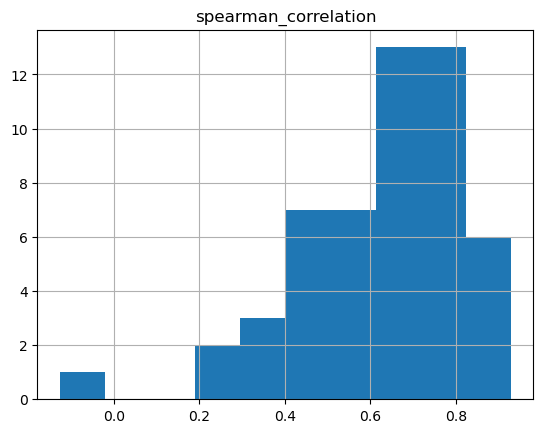

In [50]:

# Define a function to calculate Spearman correlation for a group
def calculate_spearman_correlation(group):
    shifted_cases = group['cases_new'].shift(-1)
    correlation = group['ww_index_normed_ln_lin'].corr(shifted_cases, method='spearman')
    return pd.DataFrame({'state': [group.name], 'spearman_correlation': [round(correlation,3)]})

# Group the data by 'state' and apply the correlation calculation
state_correlations = df_states.groupby('state').apply(calculate_spearman_correlation).reset_index(drop=True)

state_correlations = state_correlations.sort_values('spearman_correlation').dropna()
state_correlations.hist()

In [51]:
state_correlations['state'] = state_correlations.state.astype('string')
state_correlations = state_correlations.merge(unique_df, on='state', how='left')
state_correlations

,state,spearman_correlation,site_id_with_pcr
0,Texas,-0.126,30
1,Utah,0.242,33
2,New Mexico,0.264,12
3,Wyoming,0.318,3
4,Washington,0.363,26
5,Alaska,0.401,4
6,Hawaii,0.408,11
7,Mississippi,0.425,1
8,Iowa,0.455,11
9,Vermont,0.466,8


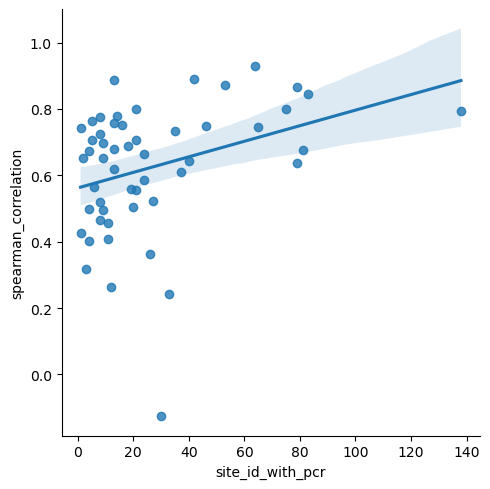

In [52]:
sns.lmplot(x='site_id_with_pcr', y='spearman_correlation',data=state_correlations)

Spearman correlation coefficients for each region (shift=-2):
                                       state  spearman_correlation
state                                                             
Texas                0                 Texas             -0.108538
Utah                 0                  Utah              0.198953
Wyoming              0               Wyoming              0.256371
Hawaii               0                Hawaii              0.307642
New Mexico           0            New Mexico              0.311265
Washington           0            Washington              0.327163
Iowa                 0                  Iowa              0.405474
Mississippi          0           Mississippi              0.427364
Kentucky             0              Kentucky              0.446912
Indiana              0               Indiana              0.484058
Delaware             0              Delaware              0.486771
Alaska               0                Alaska              0.489088


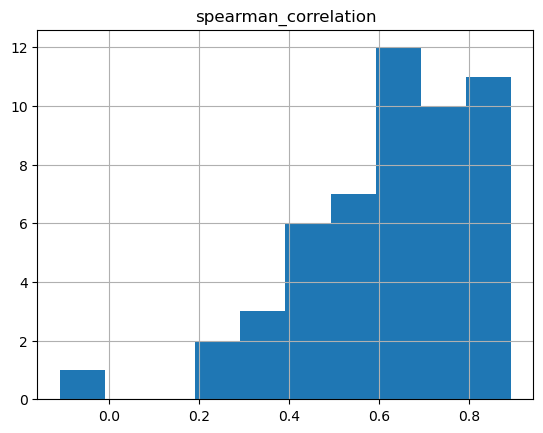

In [ ]:
for shift in [-2,-1]:
    # Define a function to calculate Spearman correlation for a group
    def calculate_spearman_correlation(group):
        shifted_cases = group['cases_new'].shift(shift)
        correlation = group['ww_index_normed_ln_lin'].corr(shifted_cases, method='spearman')
        return pd.DataFrame({'state': [group.name], 'spearman_correlation': [correlation]})

    # Group the data by 'biobot_region' and apply the correlation calculation
    spearman_correlations = df_states.groupby('state').apply(calculate_spearman_correlation)

    # Print the Spearman correlation coefficient for each region
    print(f"Spearman correlation coefficients for each region (shift={shift}):")
    print(spearman_correlations.sort_values('spearman_correlation'))
    spearman_correlations.hist()